In [52]:
import matplotlib.pyplot as plt

In [25]:
import numpy as np
#from ..util.warping_functions import *
from GPy.core import GP
from GPy import likelihoods
from paramz import ObsAr
#from GPy.util.warping_functions import TanhFunction
from GPy.util.warping_functions import TanhFunction
from GPy import kern

class WarpedGP(GP):
    """
    This defines a GP Regression model that applies a 
    warping function to the output.
    """
    def __init__(self, X, Y, kernel=None, warping_function=None, warping_terms=3, normalizer=False):
        if kernel is None:
            kernel = kern.RBF(X.shape[1])
        if warping_function == None:
            self.warping_function = TanhFunction(warping_terms)
            self.warping_params = (np.random.randn(self.warping_function.n_terms * 3 + 1) * 1)
        else:
            self.warping_function = warping_function
        likelihood = likelihoods.Gaussian()
        super(WarpedGP, self).__init__(X, Y.copy(), likelihood=likelihood, kernel=kernel, normalizer=normalizer)
        self.Y_normalized = self.Y_normalized.copy()
        self.Y_untransformed = self.Y_normalized.copy()
        self.predict_in_warped_space = True
        self.link_parameter(self.warping_function)

    def set_XY(self, X=None, Y=None):
        super(WarpedGP, self).set_XY(X, Y)
        self.Y_untransformed = self.Y_normalized.copy()
        self.update_model(True)

    def parameters_changed(self):
        """
        Notice that we update the warping function gradients here.
        """
        self.Y_normalized[:] = self.transform_data()
        super(WarpedGP, self).parameters_changed()
        Kiy = self.posterior.woodbury_vector.flatten()
        self.warping_function.update_grads(self.Y_untransformed, Kiy)

    def transform_data(self):
        Y = self.warping_function.f(self.Y_untransformed.copy()).copy()
        return Y

    def log_likelihood(self):
        """
        Notice we add the jacobian of the warping function here.
        """
        ll = GP.log_likelihood(self)
        jacobian = self.warping_function.fgrad_y(self.Y_untransformed)
        return ll + np.log(jacobian).sum()

    def plot_warping(self):
        self.warping_function.plot(self.Y_untransformed.min(), self.Y_untransformed.max())

    def _get_warped_term(self, mean, std, gh_samples, pred_init=None):
        arg1 = gh_samples.dot(std.T) * np.sqrt(2)
        arg2 = np.ones(shape=gh_samples.shape).dot(mean.T)
        return self.warping_function.f_inv(arg1 + arg2, y=pred_init)

    def _get_warped_mean(self, mean, std, pred_init=None, deg_gauss_hermite=20):
        """
        Calculate the warped mean by using Gauss-Hermite quadrature.
        """
        gh_samples, gh_weights = np.polynomial.hermite.hermgauss(deg_gauss_hermite)
        gh_samples = gh_samples[:, None]
        gh_weights = gh_weights[None, :]
        return gh_weights.dot(self._get_warped_term(mean, std, gh_samples)) / np.sqrt(np.pi)

    def _get_warped_variance(self, mean, std, pred_init=None, deg_gauss_hermite=20):
        """
        Calculate the warped variance by using Gauss-Hermite quadrature.
        """
        gh_samples, gh_weights = np.polynomial.hermite.hermgauss(deg_gauss_hermite)
        gh_samples = gh_samples[:, None]
        gh_weights = gh_weights[None, :]
        arg1 = gh_weights.dot(self._get_warped_term(mean, std, gh_samples, 
                                                    pred_init=pred_init) ** 2) / np.sqrt(np.pi)
        arg2 = self._get_warped_mean(mean, std, pred_init=pred_init,
                                     deg_gauss_hermite=deg_gauss_hermite)
        return arg1 - (arg2 ** 2)

    def predict(self, Xnew, kern=None, pred_init=None, Y_metadata=None,
                median=False, deg_gauss_hermite=20, likelihood=None):
        """
        Prediction results depend on:
        - The value of the self.predict_in_warped_space flag
        - The median flag passed as argument
        The likelihood keyword is never used, it is just to follow the plotting API.
        """
        #mu, var = GP._raw_predict(self, Xnew)
        # now push through likelihood
        #mean, var = self.likelihood.predictive_values(mu, var)
        
        mean, var = super(WarpedGP, self).predict(Xnew, kern=kern, full_cov=False, likelihood=likelihood)


        if self.predict_in_warped_space:
            std = np.sqrt(var)
            if median:
                wmean = self.warping_function.f_inv(mean, y=pred_init)
            else:
                wmean = self._get_warped_mean(mean, std, pred_init=pred_init,
                                              deg_gauss_hermite=deg_gauss_hermite).T
            wvar = self._get_warped_variance(mean, std, pred_init=pred_init,
                                             deg_gauss_hermite=deg_gauss_hermite).T
        else:
            wmean = mean
            wvar = var
        return wmean, wvar

    def predict_quantiles(self, X, quantiles=(2.5, 97.5), Y_metadata=None, likelihood=None, kern=None):
        """
        Get the predictive quantiles around the prediction at X

        :param X: The points at which to make a prediction
        :type X: np.ndarray (Xnew x self.input_dim)
        :param quantiles: tuple of quantiles, default is (2.5, 97.5) which is the 95% interval
        :type quantiles: tuple
        :returns: list of quantiles for each X and predictive quantiles for interval combination
        :rtype: [np.ndarray (Xnew x self.input_dim), np.ndarray (Xnew x self.input_dim)]
        """
        qs = super(WarpedGP, self).predict_quantiles(X, quantiles, Y_metadata=Y_metadata, likelihood=likelihood, kern=kern)
        if self.predict_in_warped_space:
            return [self.warping_function.f_inv(q) for q in qs]
        return qs
        #m, v = self._raw_predict(X,  full_cov=False)
        #if self.normalizer is not None:
        #    m, v = self.normalizer.inverse_mean(m), self.normalizer.inverse_variance(v)
        #a, b = self.likelihood.predictive_quantiles(m, v, quantiles, Y_metadata)
        #if not self.predict_in_warped_space:
        #    return [a, b]
        #new_a = self.warping_function.f_inv(a)
        #new_b = self.warping_function.f_inv(b)
        #return [new_a, new_b]

    def log_predictive_density(self, x_test, y_test, Y_metadata=None):
        """
        Calculation of the log predictive density. Notice we add
        the jacobian of the warping function here.

        .. math:
            p(y_{*}|D) = p(y_{*}|f_{*})p(f_{*}|\mu_{*}\\sigma^{2}_{*})

        :param x_test: test locations (x_{*})
        :type x_test: (Nx1) array
        :param y_test: test observations (y_{*})
        :type y_test: (Nx1) array
        :param Y_metadata: metadata associated with the test points
        """
        mu_star, var_star = self._raw_predict(x_test)
        fy = self.warping_function.f(y_test)
        ll_lpd = self.likelihood.log_predictive_density(fy, mu_star, var_star, Y_metadata=Y_metadata)
        return ll_lpd + np.log(self.warping_function.fgrad_y(y_test))

In [18]:
import numpy as np
from GPy.core.parameterization import Parameterized, Param
from paramz.transformations import Logexp
import sys


class WarpingFunction(Parameterized):
    """
    abstract function for warping
    z = f(y)
    """

    def __init__(self, name):
        super(WarpingFunction, self).__init__(name=name)
        self.rate = 0.1

    def f(self, y, psi):
        """function transformation
        y is a list of values (GP training data) of shape [N, 1]
        """
        raise NotImplementedError

    def fgrad_y(self, y, psi):
        """gradient of f w.r.t to y"""
        raise NotImplementedError

    def fgrad_y_psi(self, y, psi):
        """gradient of f w.r.t to y"""
        raise NotImplementedError

    def f_inv(self, z, max_iterations=250, y=None):
        """
        Calculate the numerical inverse of f. This should be
        overwritten for specific warping functions where the
        inverse can be found in closed form.

        :param max_iterations: maximum number of N.R. iterations
        """

        z = z.copy()
        y = np.ones_like(z)

        it = 0
        update = np.inf
        while np.abs(update).sum() > 1e-10 and it < max_iterations:
            fy = self.f(y)
            fgrady = self.fgrad_y(y)
            update = (fy - z) / fgrady
            y -= self.rate * update
            it += 1
        #if it == max_iterations:
        #    print("WARNING!!! Maximum number of iterations reached in f_inv ")
        #    print("Sum of roots: %.4f" % np.sum(fy - z))
        return y

    def plot(self, xmin, xmax):
        y = np.arange(xmin, xmax, 0.01)
        f_y = self.f(y)
        from matplotlib import pyplot as plt
        plt.figure()
        plt.plot(y, f_y)
        plt.xlabel('y')
        plt.ylabel('f(y)')
        plt.title('warping function')
        plt.show()

class TanhFunction(WarpingFunction):
    """
    This is the function proposed in Snelson et al.:
    A sum of tanh functions with linear trends outside
    the range. Notice the term 'd', which scales the
    linear trend.
    """
    def __init__(self, n_terms=3, initial_y=None):
        """
        n_terms specifies the number of tanh terms to be used
        """
        self.n_terms = n_terms
        self.num_parameters = 3 * self.n_terms + 1
        self.psi = np.ones((self.n_terms, 3))
        super(TanhFunction, self).__init__(name='warp_tanh')
        self.psi = Param('psi', self.psi)
        self.psi[:, :2].constrain_positive()
        self.d = Param('%s' % ('d'), 1.0, Logexp())
        self.link_parameter(self.psi)
        self.link_parameter(self.d)
        self.initial_y = initial_y

    def f(self, y):
        """
        Transform y with f using parameter vector psi
        psi = [[a,b,c]]

        :math:`f = (y * d) + \\sum_{terms} a * tanh(b *(y + c))`
        """
        d = self.d
        mpsi = self.psi
        z = d * y.copy()
        for i in range(len(mpsi)):
            a, b, c = mpsi[i]
            z += a * np.tanh(b * (y + c))
        return z

    def fgrad_y(self, y, return_precalc=False):
        """
        gradient of f w.r.t to y ([N x 1])

        :returns: Nx1 vector of derivatives, unless return_precalc is true, 
        then it also returns the precomputed stuff
        """
        d = self.d
        mpsi = self.psi

        # vectorized version
        S = (mpsi[:,1] * (y[:,:,None] + mpsi[:,2])).T
        R = np.tanh(S)
        D = 1 - (R ** 2)

        GRAD = (d + (mpsi[:,0:1][:,:,None] * mpsi[:,1:2][:,:,None] * D).sum(axis=0)).T

        if return_precalc:
            return GRAD, S, R, D

        return GRAD

    def fgrad_y_psi(self, y, return_covar_chain=False):
        """
        gradient of f w.r.t to y and psi

        :returns: NxIx4 tensor of partial derivatives
        """
        mpsi = self.psi

        w, s, r, d = self.fgrad_y(y, return_precalc=True)
        gradients = np.zeros((y.shape[0], y.shape[1], len(mpsi), 4)) #d2f/dydpsi
        for i in range(len(mpsi)):
            a,b,c  = mpsi[i]
            gradients[:, :, i, 0] = (b * (1.0/np.cosh(s[i])) ** 2).T  # .T to make the shape to be Nx1
            gradients[:, :, i, 1] = a * (d[i] - 2.0 * s[i] * r[i] * (1.0/np.cosh(s[i])) ** 2).T
            gradients[:, :, i, 2] = (-2.0 * a * (b ** 2) * r[i] * ((1.0 / np.cosh(s[i])) ** 2)).T
        gradients[:, :, 0, 3] = 1.0

        if return_covar_chain:  #df/dpsi
            covar_grad_chain = np.zeros((y.shape[0], y.shape[1], len(mpsi), 4))
            for i in range(len(mpsi)):
                a,b,c = mpsi[i]
                covar_grad_chain[:, :, i, 0] = (r[i]).T
                covar_grad_chain[:, :, i, 1] = (a * (y + c) * ((1.0 / np.cosh(s[i])) ** 2).T)
                covar_grad_chain[:, :, i, 2] = a * b * ((1.0 / np.cosh(s[i])) ** 2).T
            covar_grad_chain[:, :, 0, 3] = y
            return gradients, covar_grad_chain

        return gradients

    def update_grads(self, Y_untransformed, Kiy):
        grad_y = self.fgrad_y(Y_untransformed)
        grad_y_psi, grad_psi = self.fgrad_y_psi(Y_untransformed,
                                                return_covar_chain=True)
        djac_dpsi = ((1.0 / grad_y[:, :, None, None]) * grad_y_psi).sum(axis=0).sum(axis=0)
        dquad_dpsi = (Kiy[:, None, None, None] * grad_psi).sum(axis=0).sum(axis=0)

        warping_grads = -dquad_dpsi + djac_dpsi

        self.psi.gradient[:] = warping_grads[:, :-1]
        self.d.gradient[:] = warping_grads[0, -1] 


In [26]:
X = np.random.randn(20, 1)
Y = np.sin(X) + np.random.randn(20, 1)*0.05

m = WarpedGP(X, Y,warping_function=TanhFunction(1))

In [27]:
m

gp.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,
warp_tanh.psi,"(1, 3)",{+ve},
warp_tanh.d,1.0,+ve,


In [11]:
GRAD, S, R, D = m.warping_function.fgrad_y(Y,True)

In [14]:
print(S[1].shape)
print(R[1].shape)
print(D[1].shape)

(1, 20)
(1, 20)
(1, 20)


# LogC

In [64]:
class LogC(WarpingFunction):
    """
    This is the function proposed in Snelson et al.:
    A sum of tanh functions with linear trends outside
    the range. Notice the term 'd', which scales the
    linear trend.
    """
    def __init__(self, lower,upper,n_terms =1, initial_y=None):
        """
        n_terms specifies the number of tanh terms to be used
        """
        self.n_terms = n_terms
        self.num_parameters = 1
        self.psi = np.ones((self.n_terms, 1))
        super(LogC, self).__init__(name='logC')
        self.psi = Param('psi', self.psi)  #Param will register psi as a parameter
        self.psi[:, :].constrain_bounded(lower,upper) #put constraint in the psi space
        self.link_parameter(self.psi)
        self.initial_y = initial_y

    def f(self, y):  # f is the warping function

        psi = self.psi
        
        z_temp = np.log(y+psi)
        mean_temp = np.mean(z_temp)
        
        z = z_temp-mean_temp

        return z

    def fgrad_y(self, y, return_precalc=False):
        """
        gradient of f w.r.t to y ([N x 1])

        :returns: Nx1 vector of derivatives, unless return_precalc is true, 
        then it also returns the precomputed stuff
        """

        psi = self.psi
        
        N = y.shape[0]

        GRAD = (N-1)/N *1/(y+psi)

        return GRAD

    def fgrad_y_psi(self, y, return_covar_chain=False):
        """
        gradient of f w.r.t to y and psi

        :returns: NxIx4 tensor of partial derivatives
        """
        psi = self.psi
        
        N = y.shape[0]

        gradients = np.zeros((y.shape[0], y.shape[1], len(psi), 1))
        for i in range(len(psi)):
    
            gradients[:, :, i, 0] = (N-1)/N * (-1/(y+psi)**2)  #this should be of the shape Nx1
            

        if return_covar_chain:
            covar_grad_chain = np.zeros((y.shape[0], y.shape[1], len(psi), 1))
            
            
            for i in range(len(psi)):
                mean_temp = np.mean(1/(y+psi))
                covar_grad_chain[:, :, i, 0] = 1/(y+psi)-mean_temp
                
            return gradients, covar_grad_chain

        return gradients

    def update_grads(self, Y_untransformed, Kiy):
        grad_y = self.fgrad_y(Y_untransformed)
        grad_y_psi, grad_psi = self.fgrad_y_psi(Y_untransformed,
                                                return_covar_chain=True)
        djac_dpsi = ((1.0 / grad_y[:, :, None, None]) * grad_y_psi).sum(axis=0).sum(axis=0)
        dquad_dpsi = (Kiy[:, None, None, None] * grad_psi).sum(axis=0).sum(axis=0)

        warping_grads = -dquad_dpsi + djac_dpsi

        self.psi.gradient[:] = warping_grads[:, :]

reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance



Name : GP regression
Objective : -85.5482574829223
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  rbf.variance             |  1.7471825003913093  |  0.0001,10.0  |        
  rbf.lengthscale          |   2.305542004280916  |   0.01,10.0   |        
  Gaussian_noise.variance  |               1e-06  |   +ve fixed   |        


{'dataplot': [<matplotlib.collections.PathCollection at 0x7fd0c862fee0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7fd0c863c3d0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7fd0c863c5e0>]}

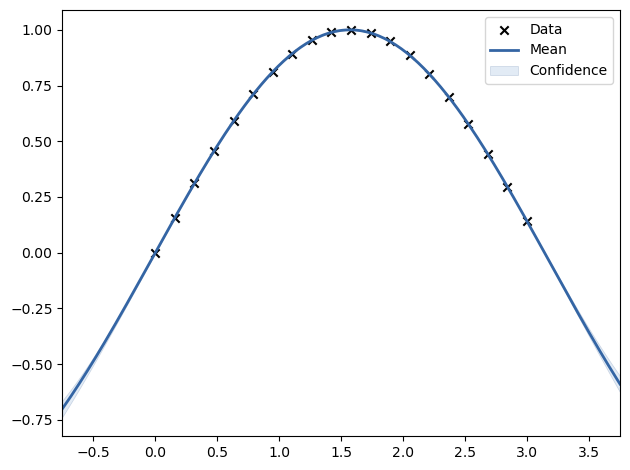

In [120]:
# normal GP
import GPy
X = np.linspace(0,3,20).reshape(-1,1)
Y = np.sin(X) #+ np.random.randn(20, 1)*0.05


kernel = GPy.kern.RBF(input_dim=1,lengthscale= 1,variance=1)  #np.sqrt(res[0])
m = GPy.models.GPRegression(X.reshape(-1,1), Y.reshape(-1,1),kernel)
m.rbf.lengthscale.constrain_bounded(0.01,10)
m.rbf.variance.constrain_bounded(0.01**2,10)
m.Gaussian_noise.fix(1e-6)
m.optimize()
print(m)
m.plot()

array([0])

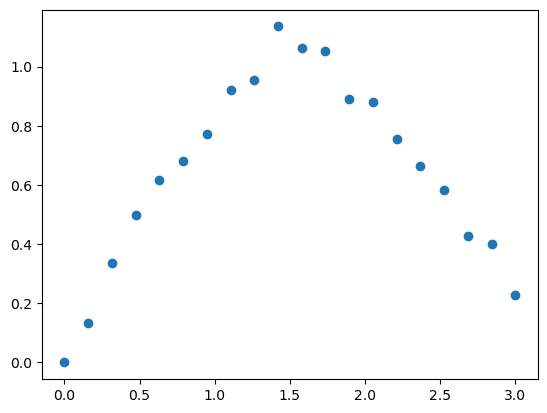

In [109]:
# logGP
X = np.linspace(0,3,20).reshape(-1,1)
Y = np.sin(X) + np.random.randn(20, 1)*0.05

lower = -np.min(Y)+10**(-6)
upper = lower+1000
plt.scatter(X,Y)

m = WarpedGP(X, Y,warping_function=LogC(lower=lower,upper=upper,n_terms =1))
m.Gaussian_noise.fix(1e-6)

In [110]:
m.optimize()

In [111]:
m

gp.,value,constraints,priors
rbf.variance,0.0002448256228629417,+ve,
rbf.lengthscale,1.4082206951356744,+ve,
Gaussian_noise.variance,1e-06,+ve fixed,
logC.psi,[47.55432116],"0.0013805649159010045,1000.0013805649158",


In [112]:
print('lengthscale: ',m.rbf.lengthscale.item()	)
print('variance: ',m.rbf.variance.item()	)
print('C: ',m.logC.psi.item()	)

lengthscale:  1.4082206951356744
variance:  0.0002448256228629417
C:  47.554321159504106


# Test accuracy

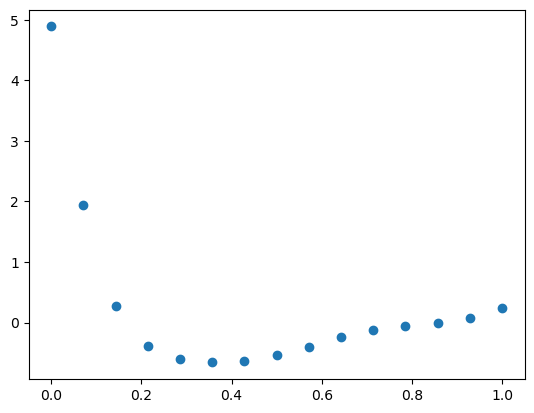

In [190]:
np.random.seed(0)


X_init = np.array([0.0]).reshape(-1,1)
Y_init = np.array([0.0]).reshape(-1,1)

kernel = GPy.kern.RBF(input_dim=1,lengthscale= 0.2,variance=0.5)  #np.sqrt(res[0])
model_test = GPy.models.GPRegression(X_init, Y_init,kernel)

X_test = np.linspace(0,1,15).reshape(-1,1)
Y_test = np.exp(0.5+model_test.posterior_samples_f(X_test,size=1).reshape(-1,1))-1

plt.scatter(X_test,Y_test)

In [200]:
lower = -np.min(Y)+10**(-6)
upper = lower+5

m = WarpedGP(X_test, Y_test,warping_function=LogC(lower=lower,upper=upper,n_terms =1))
m.rbf.lengthscale.constrain_bounded(0.01,10)
m.rbf.variance.constrain_bounded(0.01**2,10)
m.Gaussian_noise.fix(1e-6)

for i in range(3**3):
    try:
        np.random.seed(i)
        m.optimize()
    except:
        print('oh')
        pass

reconstraining parameters gp.rbf.lengthscale
reconstraining parameters gp.rbf.variance
 /tmp/ipykernel_85179/1747888806.py:25: RuntimeWarning:invalid value encountered in log
 /tmp/ipykernel_85179/3416887044.py:54: RuntimeWarning:invalid value encountered in log


In [199]:
m

gp.,value,constraints,priors
rbf.variance,1.4467692215389523,"0.0001,10.0",
rbf.lengthscale,0.2510515515917751,"0.01,10.0",
Gaussian_noise.variance,1e-06,+ve fixed,
logC.psi,[0.98010803],"1e-06,5.000001",


use my own package

In [171]:
from known_boundary.GP import optimise,optimise_warp,optimise_warp_no_boundary

res = optimise_warp_no_boundary(X_test, Y_test,+10)
lengthscale = np.sqrt(res[0])
variance = res[1]
c = res[2]

print(lengthscale)
print(variance)
print(c)


0.250565282981674
1.441218463225212
0.9816499969245152


In [131]:
X_test.shape

(8, 1)

In [132]:
Y_test.shape

(8, 1)

In [ ]:

class LogFunction(WarpingFunction):
    """
    Easy wrapper for applying a fixed log warping function to
    positive-only values.
    The closed_inverse flag should only be set to False for
    debugging and testing purposes.
    """
    def __init__(self, closed_inverse=True):
        self.num_parameters = 0
        super(LogFunction, self).__init__(name='log')
        if closed_inverse:
            self.f_inv = self._f_inv

    def f(self, y):
        return np.log(y)

    def fgrad_y(self, y):
        return 1. / y

    def update_grads(self, Y_untransformed, Kiy):
        pass

    def fgrad_y_psi(self, y, return_covar_chain=False):
        if return_covar_chain:
            return 0, 0
        return 0

    def _f_inv(self, z, y=None):
        return np.exp(z)


class IdentityFunction(WarpingFunction):
    """
    Identity warping function. This is for testing and sanity check purposes
    and should not be used in practice.
    The closed_inverse flag should only be set to False for
    debugging and testing purposes.
    """
    def __init__(self, closed_inverse=True):
        self.num_parameters = 0
        super(IdentityFunction, self).__init__(name='identity')
        if closed_inverse:
            self.f_inv = self._f_inv
        
    def f(self, y):
        return y

    def fgrad_y(self, y):
        return np.ones(y.shape)

    def update_grads(self, Y_untransformed, Kiy):
        pass

    def fgrad_y_psi(self, y, return_covar_chain=False):
        if return_covar_chain:
            return 0, 0
        return 0
        
    def _f_inv(self, z, y=None):
        return z